# Evaluate likelihood ratio

In [3]:
import sys, os
import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm

## Data

In [11]:
filenames = [
    "carl_fix",
    "alices_fix",
    "carl_fix_log",
    "alices_fix_log",
    "carl_mass",
    "alices_mass",
    "carl_mass_log",
    "alices_mass_log",
    "carl_mass_pre",
    "alices_mass_pre",
    "carl_align",
    "carl_align_log",
    "alices_align_log",
]
labels = [
    "Fix: CARL",
    "Fix: ALICES",
    "Fix: CARL-log",
    "Fix: ALICES-log",
    "Mass: CARL",
    "Mass: ALICES",
    "Mass: CARL-log",
    "Mass: ALICES-log",
    "Mass: CARL-pre",
    "Mass: ALICES-pre",
    "Align: CARL",
    "Align: CARL-log",
    "Align: ALICES-log",
    "Full: CARL",
    "Full: ALICES",
    "Full: CARL-aux",
]

nmethods = len(filenames)
ncols = 3
nrows = (nmethods - 1) // ncols + 1

In [12]:
llrs = np.asarray([np.load("../data/results/llr_{}_grid.npy".format(filename)) for filename in filenames])
expected_llr = np.mean(llrs, axis=-1)

## Parameter grids

In [15]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Expected LLR

In [16]:
llrmin, llrmax = 0., 10.

n_for_lines = [10]
thresholds = [1. / n * chi2.isf(0.05, df=2) for n in n_for_lines]
contour_ls = ["-", "--", ":"]

llr_cmap = "viridis_r"

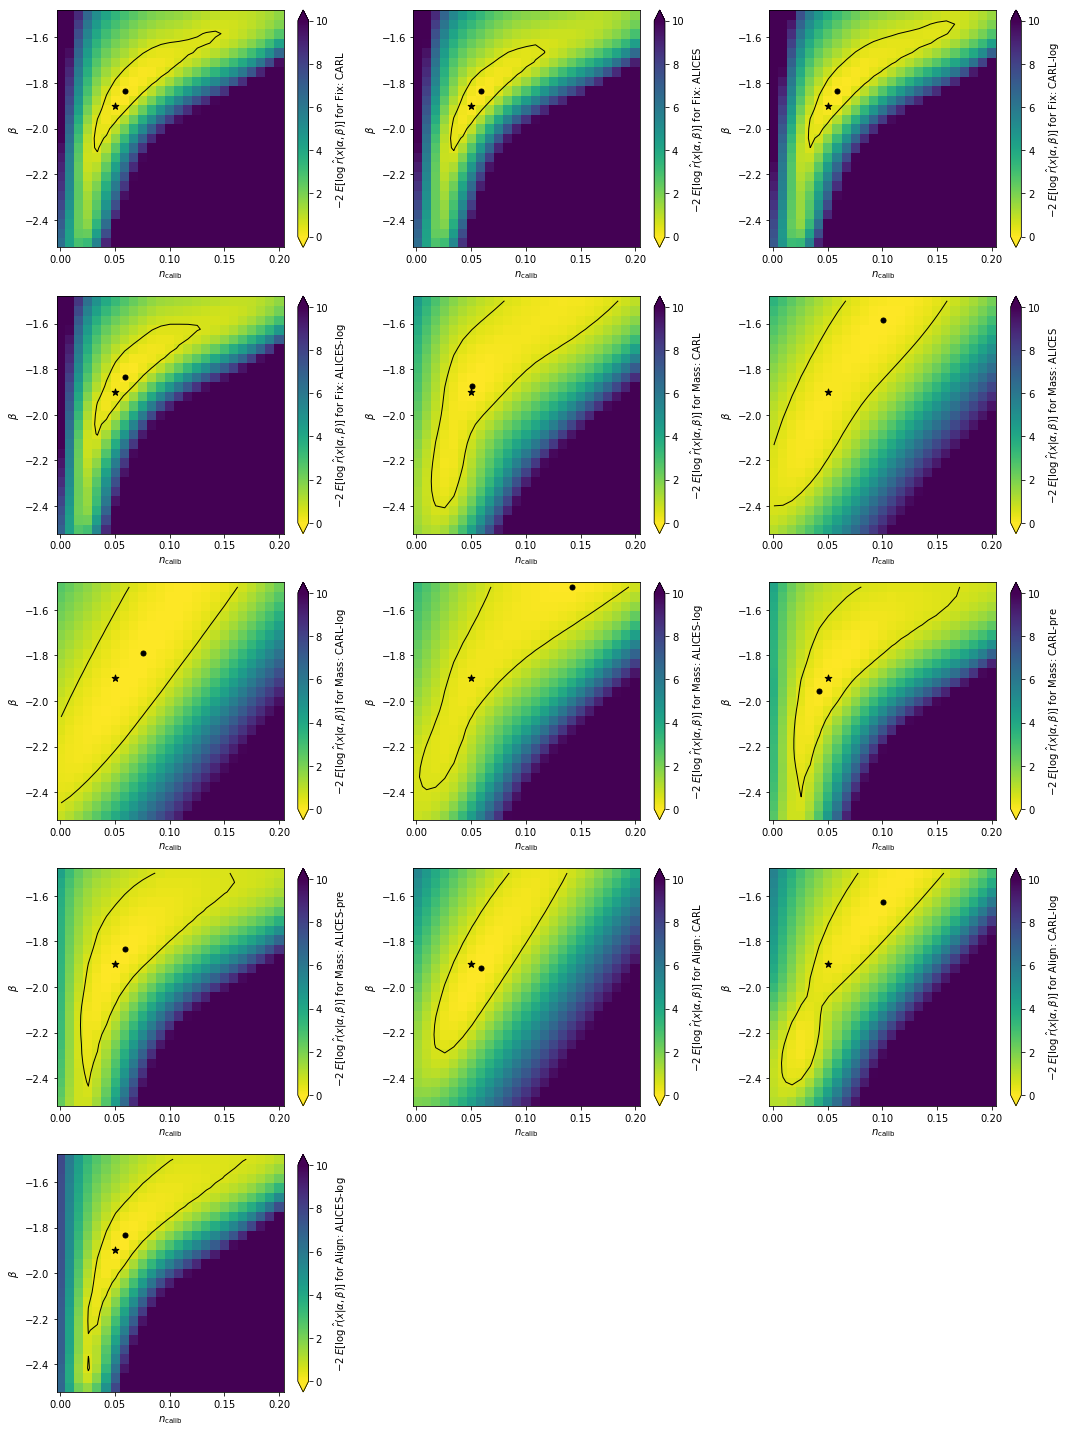

In [17]:
fig = plt.figure(figsize=(5. * ncols, 4. * nrows))
ax_xs = []
ax_rs = []

for k in range(nmethods):
    ax = plt.subplot(nrows, ncols, k + 1)

    i_mle = np.argmax(expected_llr[k])
    theta_mle = theta_grid[i_mle]
    z = np.clip(-2. * (expected_llr[k] - expected_llr[k][i_mle]), llrmin, llrmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((resolution, resolution)),
        norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
        cmap=llr_cmap
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    cs = plt.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        z.reshape((resolution, resolution)),
        thresholds,
        colors="black",
        linewidths=1.,
        linestyles=contour_ls,
    )
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=25., color='black', marker='o')

    plt.xlabel(r'$n_{\mathrm{calib}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; E[\log \;\hat{r}(x | \alpha, \beta)]$ for '+ labels[k])
    #plt.clabel(cs)
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/expected_llr.pdf")